In [1]:
!pip install -q keras

In [2]:
# Artificial Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn_Modelling.csv')
X = dataset.iloc[:, 3:13]
y = dataset.iloc[:, 13]

#Create dummy variables
geography=pd.get_dummies(X["Geography"],drop_first=True)
gender=pd.get_dummies(X['Gender'],drop_first=True)

## Concatenate the Data Frames
X=pd.concat([X,geography,gender],axis=1)

## Drop Unnecessary columns
X=X.drop(['Geography','Gender'],axis=1)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Part 2 - Now let's make the ANN!

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'he_uniform',activation='relu',input_dim = 11))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
model_history=classifier.fit(X_train, y_train,validation_split=0.33, batch_size = 10, epochs = 100)

Epoch 1/100
536/536 [==============================] - 19s 5ms/step - loss: 0.5852 - accuracy: 0.7977 - val_loss: 0.5427 - val_accuracy: 0.7955
Epoch 2/100
536/536 [==============================] - 2s 4ms/step - loss: 0.5407 - accuracy: 0.7940 - val_loss: 0.5181 - val_accuracy: 0.7955
Epoch 3/100
536/536 [==============================] - 2s 4ms/step - loss: 0.5009 - accuracy: 0.8063 - val_loss: 0.5028 - val_accuracy: 0.7955
Epoch 4/100
536/536 [==============================] - 2s 4ms/step - loss: 0.4947 - accuracy: 0.7991 - val_loss: 0.4912 - val_accuracy: 0.7955
Epoch 5/100
536/536 [==============================] - 2s 4ms/step - loss: 0.4845 - accuracy: 0.7975 - val_loss: 0.4820 - val_accuracy: 0.7955
Epoch 6/100
536/536 [==============================] - 2s 4ms/step - loss: 0.4739 - accuracy: 0.7959 - val_loss: 0.4742 - val_accuracy: 0.7955
Epoch 7/100
536/536 [==============================] - 2s 4ms/step - loss: 0.4606 - accuracy: 0.8001 - val_loss: 0.4671 - val_accuracy: 0.794

KeyError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


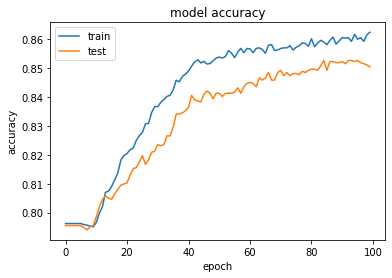

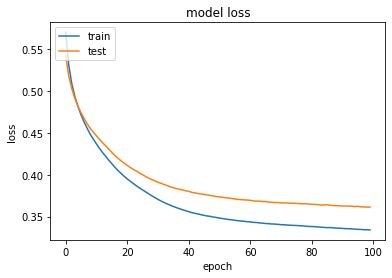

In [3]:
# list all data in history

print(model_history.history.keys())
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)

In [4]:
cm

array([[1506,   89],
       [ 192,  213]])

In [5]:
score

0.8595

**Hyperparameter Tunning with Keras Tuner**

In [6]:
!pip install -q keras-tuner

     |████████████████████████████████| 71kB 5.9MB/s 


In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [15]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='ChurnModelling')

In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [18]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 29s]
val_mean_absolute_error: 0.15872965256373087

Best val_mean_absolute_error So Far: 0.14850426216920218
Total elapsed time: 00h 02m 18s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

Results summary
Results in project/ChurnModelling
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 7
units_0: 352
units_1: 160
learning_rate: 0.0001
units_2: 160
units_3: 192
units_4: 128
units_5: 352
units_6: 32
units_7: 128
units_8: 416
units_9: 96
units_10: 128
units_11: 128
units_12: 384
units_13: 160
units_14: 384
units_15: 448
units_16: 384
Score: 0.14850426216920218
Trial summary
Hyperparameters:
num_layers: 9
units_0: 96
units_1: 96
learning_rate: 0.0001
units_2: 64
units_3: 160
units_4: 480
units_5: 480
units_6: 416
units_7: 96
units_8: 96
units_9: 160
units_10: 32
units_11: 448
units_12: 480
units_13: 160
units_14: 224
units_15: 416
units_16: 384
Score: 0.15020651618639627
Trial summary
Hyperparameters:
num_layers: 14
units_0: 64
units_1: 448
learning_rate: 0.0001
units_2: 256
units_3: 128
units_4: 192
units_5: 416
units_6: 32
units_7: 160
units_8: 128
units_9: 320
units_10: 32
units_11: 128
units_12:

In [33]:
for i in range(1,16):
  print(f"Adding the {i} hidden layer")

Adding the 1 hidden layer
Adding the 2 hidden layer
Adding the 3 hidden layer
Adding the 4 hidden layer
Adding the 5 hidden layer
Adding the 6 hidden layer
Adding the 7 hidden layer
Adding the 8 hidden layer
Adding the 9 hidden layer
Adding the 10 hidden layer
Adding the 11 hidden layer
Adding the 12 hidden layer
Adding the 13 hidden layer
Adding the 14 hidden layer
Adding the 15 hidden layer


In [36]:
# Initialising the ANN
classifierHyper = Sequential()

In [37]:
# Trial summary
# Hyperparameters:
# num_layers: 17
# units_0: 416
# units_1: 448
# learning_rate: 0.001
# units_2: 32
# units_3: 32
# units_4: 32
# units_5: 32
# units_6: 32
# units_7: 32
# units_8: 32
# units_9: 32
# units_10: 32
# units_11: 32
# units_12: 32
# units_13: 32
# units_14: 32
# units_15: 32
# units_16: 32
# Score: 0.18947872519493103

# Adding the input layer and the first hidden layer
classifierHyper.add(Dense(units = 416, kernel_initializer = 'he_uniform',activation='relu',input_dim = 11))

#Adding the second hidden layer
classifierHyper.add(Dense(units = 448, kernel_initializer = 'he_uniform',activation='relu'))

for i in range(1,16):
  print(f"Adding the {i} hidden layer")
  classifierHyper.add(Dense(units = 32, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the output layer
classifierHyper.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
classifierHyper.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
model_history=classifierHyper.fit(X_train, y_train,validation_split=0.33, batch_size = 10, epochs = 100)

Adding the 1 hidden layer
Adding the 2 hidden layer
Adding the 3 hidden layer
Adding the 4 hidden layer
Adding the 5 hidden layer
Adding the 6 hidden layer
Adding the 7 hidden layer
Adding the 8 hidden layer
Adding the 9 hidden layer
Adding the 10 hidden layer
Adding the 11 hidden layer
Adding the 12 hidden layer
Adding the 13 hidden layer
Adding the 14 hidden layer
Adding the 15 hidden layer
Epoch 1/100
536/536 [==============================] - 8s 10ms/step - loss: 0.5186 - accuracy: 0.7878 - val_loss: 0.4114 - val_accuracy: 0.8296
Epoch 2/100
536/536 [==============================] - 5s 9ms/step - loss: 0.3936 - accuracy: 0.8297 - val_loss: 0.3908 - val_accuracy: 0.8334
Epoch 3/100
536/536 [==============================] - 5s 9ms/step - loss: 0.3595 - accuracy: 0.8534 - val_loss: 0.3757 - val_accuracy: 0.8436
Epoch 4/100
536/536 [==============================] - 4s 8ms/step - loss: 0.3326 - accuracy: 0.8585 - val_loss: 0.3643 - val_accuracy: 0.8512
Epoch 5/100
536/536 [==========